In [14]:
import rasterio
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm
from matplotlib.colors import BoundaryNorm, LinearSegmentedColormap, ListedColormap
from shapely.geometry import mapping
from rasterio import mask as msk
import geopandas as gpd
import pandas as pd
from pathlib import Path

# cartopy imports
import cartopy.crs as ccrs
import cartopy.feature as cfeature

data_path = Path.home()/'OneDrive'/'Kirstin'/'Uni'/'Year4'/'MSciProject'/'data_files'

##### extracting data

In [15]:
tif_file_world = rasterio.open(data_path/'population_files'/'GHS_POP_E2015_GLOBE_R2023A_4326_30ss_V1_0.tif')

ghs_world = tif_file_world.read()

In [16]:
df = gpd.read_file(data_path / 'population_files' / 'NaturalEarth' / 'ne_10m_admin_0_countries.shp')
western_europe = df.loc[df['ADMIN'].isin(['United Kingdom', 'Germany', 'Austria', 'Czechia',
                                          'Italy', 'Denmark', 'Luxembourg',
                                          'Belgium', 'Switzerland', 'Ireland',
                                          'Iceland', 'Greenland', 'Norway', 'Sweden',
                                          'Finland', 'Estonia', 'Latvia', 'Lithuania',
                                          'Poland', 'Slovakia', 'Hungary', 'Slovenia',
                                          'Croatia', 'Bosnia and Herzegovina', 'Serbia',
                                          'Montenegro', 'Kosovo', 'Albania', 'Macedonia',
                                          'Greece', 'Bulgaria', 'Romania', 'Moldova',
                                          'Tunisia', 'Morocco', 'Algeria', 'Libya', 'Egypt',])]

# For each country, create a new GeoDataFrame with the desired geometry
def update_geometry(country_df, index):
    if not country_df.empty:
        geom = country_df.iloc[0].geometry
        # Check if the geometry is a MultiPolygon and has enough elements
        if geom.type == 'MultiPolygon' and len(geom.geoms) > index:
            # Access the specific Polygon within the MultiPolygon
            selected_geom = [geom.geoms[index]]
            return gpd.GeoDataFrame(country_df, geometry=selected_geom)
    return country_df

france = update_geometry(df.loc[df['ADMIN'] == 'France'], 1)
spain = update_geometry(df.loc[df['ADMIN'] == 'Spain'], 2)
netherlands = update_geometry(df.loc[df['ADMIN'] == 'Netherlands'], 0)
portugal = update_geometry(df.loc[df['ADMIN'] == 'Portugal'], 0)

# Concatenate all GeoDataFrames
western_europe = pd.concat([western_europe, france, spain, netherlands, portugal])

C:\Users\kirst\AppData\Local\Temp\ipykernel_60044\3030000089.py:18: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom.type == 'MultiPolygon' and len(geom.geoms) > index:


In [17]:
europe_array, clipped_transform = msk.mask(tif_file_world, [mapping(geom) for geom in western_europe.geometry.tolist()], crop=True)

##### Plotting w cartopy - europe

In [27]:
europe_array[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [18]:
our_cmap = cm.get_cmap('binary', 10)
newcolors = our_cmap(np.linspace(0, 1, 10))
background_colour = np.array([1, 1, 1, 1.0])
newcolors = np.vstack((background_colour, newcolors))
our_cmap = ListedColormap(newcolors)
bounds = [0.0, 1, 5, 10, 20, 50, 100, 200, 1000, 2000, 10000]
norm = colors.BoundaryNorm(bounds, our_cmap.N)

C:\Users\kirst\AppData\Local\Temp\ipykernel_60044\4113049895.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  our_cmap = cm.get_cmap('binary', 10)


In [19]:
# finding limits of europe_array
lat_min = clipped_transform[2]
lat_max = clipped_transform[2] + clipped_transform[0]*europe_array.shape[2]
lon_min = clipped_transform[5] + clipped_transform[4]*europe_array.shape[1]
lon_max = clipped_transform[5]

print(lat_min, lat_max, lon_min, lon_max)

lat_min, lat_max, lon_min, lon_max = -24.541249880403143, 18.842083281098283, 35.482916726764095, 66.56624993499972
print(lat_min, lat_max, lon_min, lon_max)

-73.0579163549059 36.9004165429065 -54.46708291122391 83.64124986627982
-24.541249880403143 18.842083281098283 35.482916726764095 66.56624993499972


Image dimensions: height=16573, width=13195
Cropping coordinates: left=-70, right=30, bottom=20, top=80
Array indices: start_row=8936, end_row=16136, start_col=366, end_col=12366


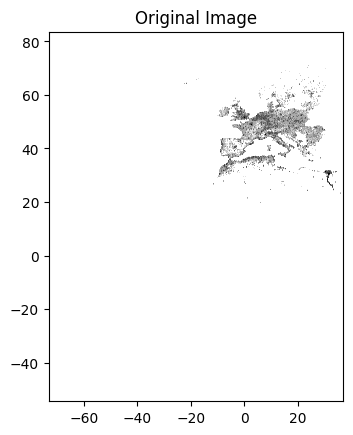

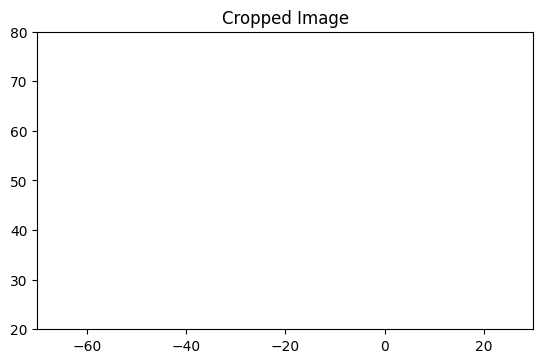

In [26]:
import matplotlib.pyplot as plt

# Define the extent of the original image
extent = [-73.0579163549059, 36.9004165429065, -54.46708291122391, 83.64124986627982]  # Assuming these are the data coordinates of the full image

# Define the desired cropping coordinates in data space
crop_left, crop_right = -70, 30
crop_bottom, crop_top = 20, 80

# Transform the desired coordinates to array indices
height, width = europe_array[0].shape
x_scale = width / (extent[1] - extent[0])
y_scale = height / (extent[3] - extent[2])

start_col = int((crop_left - extent[0]) * x_scale)
end_col = int((crop_right - extent[0]) * x_scale)
start_row = int((crop_bottom - extent[2]) * y_scale)
end_row = int((crop_top - extent[2]) * y_scale)

# Debug prints
print(f"Image dimensions: height={height}, width={width}")
print(f"Cropping coordinates: left={crop_left}, right={crop_right}, bottom={crop_bottom}, top={crop_top}")
print(f"Array indices: start_row={start_row}, end_row={end_row}, start_col={start_col}, end_col={end_col}")

# Ensure indices are within bounds
start_row = max(0, start_row)
end_row = min(height, end_row)
start_col = max(0, start_col)
end_col = min(width, end_col)

# Slice the data array to crop it
cropped_data = europe_array[0][start_row:end_row, start_col:end_col]

# Display the original image
fig, ax = plt.subplots()
im = ax.imshow(europe_array[0], extent=extent, cmap=our_cmap, norm=norm)
plt.title("Original Image")
plt.show()

# Display the cropped image
fig, ax = plt.subplots()
im = ax.imshow(cropped_data, cmap=our_cmap, norm=norm, extent=[crop_left, crop_right, crop_bottom, crop_top])
plt.title("Cropped Image")
plt.show()

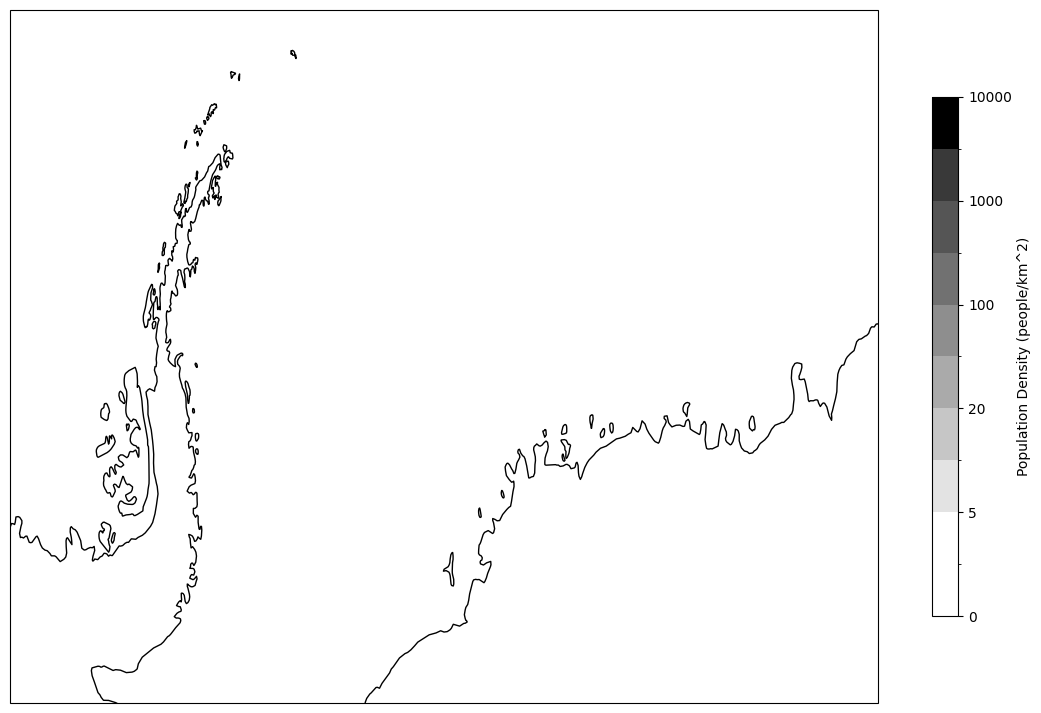

In [8]:
# Create the plot
fig, ax = plt.subplots(facecolor='#FFFFFF', subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(14, 9))

# Set the extent
ax.set_extent([lat_min-17, lat_max+6, lon_min-5, lon_max+7])

# Add features
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE, edgecolor='black')

# Display the image
im = ax.imshow(europe_array[0], norm=norm, cmap=our_cmap, extent=[lat_min, lat_max, lon_min, lon_max], zorder=0)

# Add a colorbar for the image
cbar = fig.colorbar(im, ax=ax, shrink=0.75, label='Population Density (people/km^2)')

ax.set_aspect('auto')

##### plotting with cartopy - world

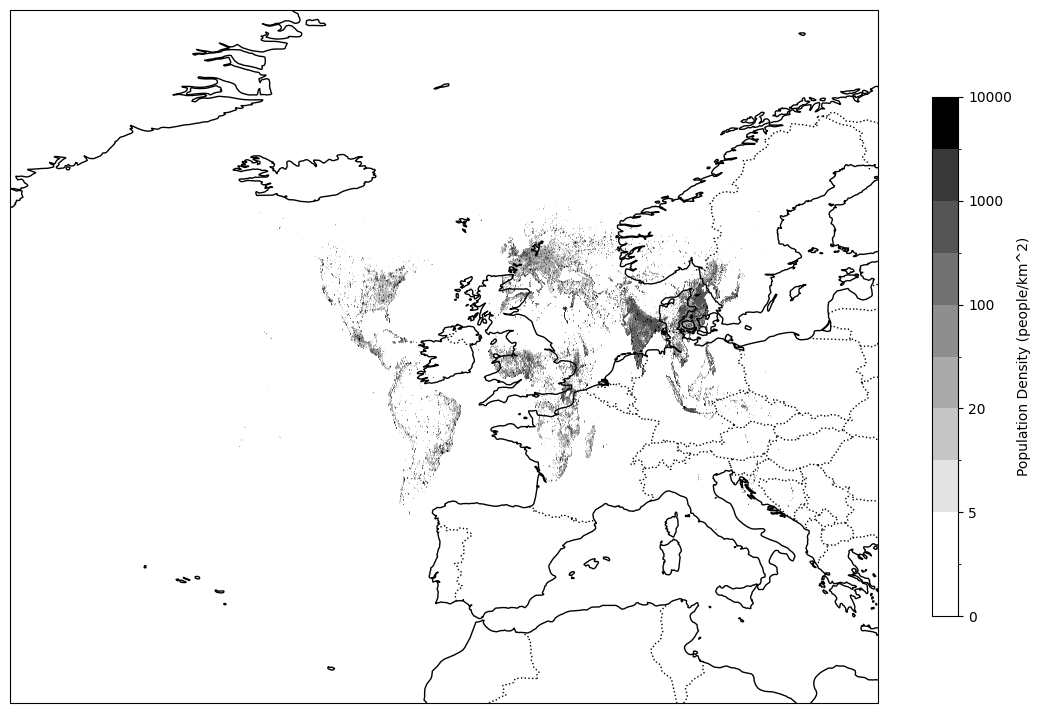

In [10]:
# Create the plot
fig, ax = plt.subplots(facecolor='#FFFFFF', subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(14, 9))

# Set the extent
ax.set_extent([lat_min-17, lat_max+6, lon_min-5, lon_max+7])

# Add features
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE, edgecolor='black')

# Display the image
im = ax.imshow(ghs_world[0], norm=norm, cmap=our_cmap, extent=[lat_min, lat_max, lon_min, lon_max], zorder=0)

# Add a colorbar for the image
cbar = fig.colorbar(im, ax=ax, shrink=0.75, label='Population Density (people/km^2)')

ax.set_aspect('auto')

##### initial plotting

In [4]:
our_cmap = cm.get_cmap('hot_r', 10)
newcolors = our_cmap(np.linspace(0, 1, 10))
background_colour = np.array([0.9882352941176471, 0.9647058823529412, 0.9607843137254902, 1.0])
newcolors = np.vstack((background_colour, newcolors))
our_cmap = ListedColormap(newcolors)
bounds = [0.0, 1, 5, 10, 20, 50, 100, 200, 1000, 2000, 10000]
norm = colors.BoundaryNorm(bounds, our_cmap.N)

C:\Users\kirst\AppData\Local\Temp\ipykernel_44308\573668819.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  our_cmap = cm.get_cmap('hot_r', 10)


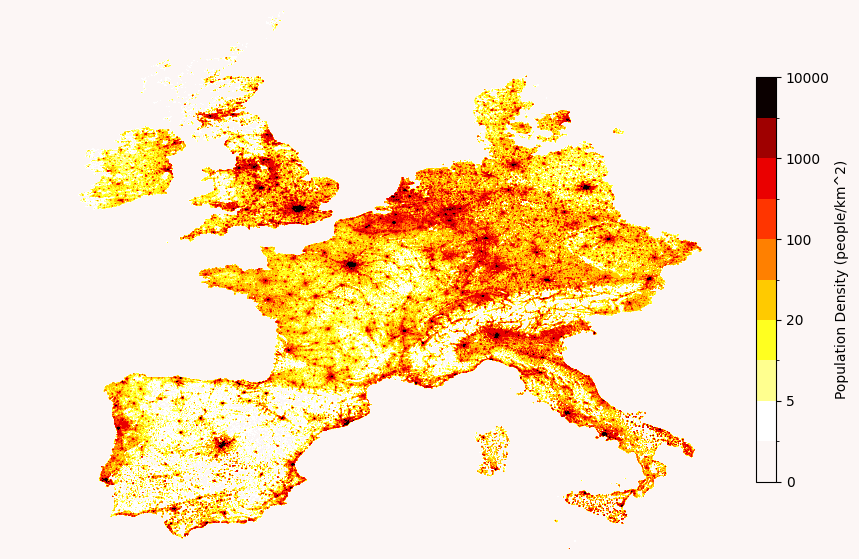

In [5]:
from shapely.geometry import mapping
from rasterio import mask as msk

europe_array, clipped_transform = msk.mask(tif_file_world, [mapping(geom) for geom in western_europe.geometry.tolist()], crop=True)

fig, ax = plt.subplots(facecolor='#FCF6F5FF')
fig.set_size_inches(14, 7)
ax.imshow(europe_array[0], norm=norm, cmap=our_cmap)
ax.axis('off')

# adding a colorbar
cbar = fig.colorbar(ax.imshow(europe_array[0], norm=norm, cmap=our_cmap), ax=ax, shrink=0.75)

# add colourbar label
cbar.set_label('Population Density (people/km^2)')

plt.show()